In [1]:
!pip install git+https://github.com/cuongvng/neural-networks-with-PyTorch.git

  Cloning https://github.com/cuongvng/neural-networks-with-PyTorch.git to /tmp/pip-req-build-nf_r4bsh
  Running command git clone -q https://github.com/cuongvng/neural-networks-with-PyTorch.git /tmp/pip-req-build-nf_r4bsh
  Created wheel for train-plot-utils: filename=train_plot_utils-1.0-cp36-none-any.whl size=4681 sha256=8dca2d26daff188bdfd743e38f4029e6ae6029742cc6dd7bf6db404af670eec4
  Stored in directory: /tmp/pip-ephem-wheel-cache-tz3nmdf5/wheels/72/21/a6/2c9910e6fda85ce86b2c6a011cbc2f3eff8020634fa90e427e
Successfully built train-plot-utils


In [2]:
!nvidia-smi

Sat Jun 20 04:26:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import sys
sys.path.append("../..")
from utils.training_helpers import train_cnn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Dataset: CIFAR 10, resize image to 224x224

In [4]:
transform = transforms.Compose([transforms.Resize((224,224)), # Resize image resolution from 32x32 to 224x224 to be compatible to AlexNet's input
                                transforms.ToTensor() # convert data from PIL image to tensor
                                ]) 
cifar_train = torchvision.datasets.CIFAR10(root="../data/", train=True, 
                                     transform=transform, 
                                     target_transform=None, 
                                     download=True)
cifar_test = torchvision.datasets.CIFAR10(root="../data/", train=False, 
                                     transform=transform, 
                                     target_transform=None, 
                                     download=True)

batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=cifar_train,
    batch_size=128,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    dataset=cifar_test,
    batch_size=128,
    shuffle=True,

)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Hãy xem thử dữ liệu có dạng như thế nào?

In [5]:
train_iter = iter(train_loader)
x, y = train_iter.next()
print(x.size())
print(y)

torch.Size([128, 3, 224, 224])
tensor([2, 4, 3, 9, 7, 7, 4, 9, 4, 5, 7, 1, 4, 7, 0, 7, 3, 0, 2, 0, 6, 3, 7, 1,
        8, 0, 5, 3, 4, 3, 2, 2, 0, 2, 0, 6, 0, 7, 1, 5, 1, 2, 9, 3, 5, 9, 3, 6,
        1, 4, 1, 7, 2, 2, 6, 2, 0, 3, 8, 1, 7, 6, 4, 0, 8, 8, 2, 9, 8, 2, 0, 5,
        8, 9, 0, 4, 8, 6, 5, 7, 4, 6, 5, 8, 5, 3, 7, 2, 0, 3, 6, 0, 2, 4, 4, 4,
        4, 8, 2, 6, 6, 9, 7, 8, 5, 2, 3, 3, 7, 0, 9, 8, 9, 3, 5, 2, 1, 6, 4, 3,
        4, 6, 5, 3, 0, 3, 2, 5])


Define the Network architechture

<figure>
    <img src="https://github.com/cuongvng/neural-networks-with-PyTorch/blob/master/CNNs/AlexNet/img/AlexNetArchitecture.png?raw=1" width="25%" class="center"/>
    <figcaption>Cấu trúc mạng AlexNet</figcaption>
</figure>

In [6]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__() # Call __init__() method of the parent class `nn.Module`
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1)
                
        self.fc1 = nn.Linear(in_features=384*2*2, out_features=4096)
        self.fc2 = nn.Linear(in_features=4096, out_features=4096)
        self.fc3 = nn.Linear(in_features=4096, out_features=10)

    def forward(self, X):
        X = X.type(torch.float)

        X = F.relu(self.conv1(X))
        X = torch.max_pool2d(X, kernel_size=3, stride=2)
        X = F.relu(self.conv2(X))
        X = torch.max_pool2d(X, kernel_size=3, stride=2)
        X = F.relu(self.conv3(X))
        X = F.relu(self.conv4(X))
        X = F.relu(self.conv5(X))
        X = F.max_pool2d(X, kernel_size=3, stride=2)
#         print(X.size()) # Uncomment this line to get the number of input features for fc1.
        
        X = torch.flatten(X, start_dim=1) # Flatten 4D tensor to 2D tensor to pass to FC.
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return X


In [7]:
net = AlexNet()

In [8]:
# Let see the shape of network parameters
for i, p in enumerate(net.parameters()):
    print(i, p.size())

0 torch.Size([96, 3, 11, 11])
1 torch.Size([96])
2 torch.Size([256, 96, 5, 5])
3 torch.Size([256])
4 torch.Size([384, 256, 3, 3])
5 torch.Size([384])
6 torch.Size([384, 384, 3, 3])
7 torch.Size([384])
8 torch.Size([384, 384, 3, 3])
9 torch.Size([384])
10 torch.Size([4096, 1536])
11 torch.Size([4096])
12 torch.Size([4096, 4096])
13 torch.Size([4096])
14 torch.Size([10, 4096])
15 torch.Size([10])


Define the loss function and optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=0.0001)

Training

Total training time: 0:12:29.261428
train loss: 0.3775164484977722 
train acc: 0.859375 
test acc: 0.7653999924659729


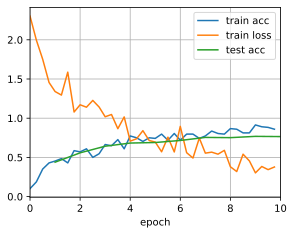

In [10]:
n_epochs = 10
train_cnn(net, device, train_loader, test_loader, optimizer, criterion, n_epochs)